---

<h2 style="text-align: center;"><b>Свёрточные нейронные сети: MNIST</b></h3>
Кошкарев 20223

---

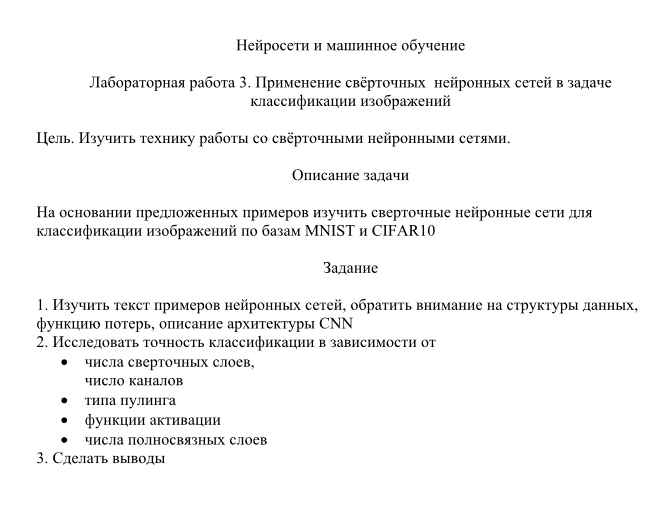

В этом ноутбке мы научимся писать свои свёрточные нейросети на фреймворке PyTorch, и протестируем их работу на датасете MNIST.

**ВНИМАНИЕ:** Рассматривается ***задача классификации изображений***.

***Свёрточная нейросеть (Convolutional Neural Network, CNN)*** - это многослойная нейросеть, имеющая в своей архитектуре помимо *полносвязных слоёв* (а иногда их может и не быть) ещё и **свёрточные слои (Conv Layers)** и **pooling-слои (Pool Layers)**.  

Собственно, название такое эти сети получили потому, что в основе их работы лежит операция **свёртки**.

Сразу же стоит сказать, что свёрточные нейросети **были придуманы прежде всего для задач, связанных с изображениями**, следовательно, на вход они тоже "ожидают" изображение.

* Например, вот так выглядит неглубокая свёрточная нейросеть, имеющая такую архитектуру:  
`Input -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<img src="https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width=800, height=600>  
  
Свёрточные нейросети (простые, есть и намного более продвинутые) почти всегда строятся по следующему правилу:  

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*L -> FC`  

то есть:  

1). ***Входной слой*** (batch картинок -- тензор размера `(batch_size, H, W, C)`)  

2). $M$ блоков (M $\ge$ 0) из свёрток и pooling-ов, причём именно в том порядке, как в формуле выше. Все эти $M$ блоков вместе называют ***feature extractor*** свёрточной нейросети, потому что эта часть сети отвечает непосредственно за формирование новых, более сложных признаков поверх тех, которые подаются (то есть, по аналогии с MLP, мы опять же переходим к новому признаковому пространству, однако здесь оно строится сложнее, чем в обычных многослойных сетях, поскольку используется операция свёртки)  

3). $L$ штук FullyConnected-слоёв (с активациями). Эту часть из $L$ FC-слоёв называют ***classificator***, поскольку эти слои отвечают непосредственно за предсказание нужно класса (сейчас рассматривается задача классификации изображений).


<h3 style="text-align: center;"><b>Свёрточная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

Так как мы сейчас рассматриваем **архитектуру CNN**, то, помимо этих компонент, в свёрточной нейросети можно настроить следующие вещи:  

- (в каждом ConvLayer) **размер фильтров (окна свёртки)** (`kernel_size`)
- (в каждом ConvLayer) **количество фильтров** (`out_channels`)  
- (в каждом ConvLayer) размер **шага окна свёртки (stride)** (`stride`)  
- (в каждом ConvLayer) **тип padding'а** (`padding`)  


- (в каждом PoolLayer) **размер окна pooling'a** (`kernel_size`)  
- (в каждом PoolLayer) **шаг окна pooling'а** (`stride`)  
- (в каждом PoolLayer) **тип pooling'а** (`pool_type`)  
- (в каждом PoolLayer) **тип padding'а** (`padding`)

Какими их берут обычно -- будет показано в примере ниже. По крайней мере, можно начинать с этих настроек, чтобы понять, какое качество "из коробки" будет у простой модели.

Посмотрим, как работает CNN на MNIST'е и на CIFAR'е:

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

**MNIST:** это набор из 70k картинок рукописных цифр от 0 до 9, написанных людьми, 60k из которых являются тренировочной выборкой (`train` dataset)), и ещё 10k выделены для тестирования модели (`test` dataset).

In [1]:
#!pip install torch torchvision

In [2]:
import torch
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Скачаем и загрузим данные в `DataLoader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [4]:
trainloader.dataset.train_data.shape

C:\Users\koshi8bit\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([60000, 28, 28])

In [5]:
testloader.dataset.test_data.shape

C:\Users\koshi8bit\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

Выведем первую картинку:

In [6]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Посмотрим, как она выглядит:

In [7]:
# преобразовать тензор в np.array
numpy_img = trainloader.dataset.train_data[0].numpy()

In [8]:
trainloader.dataset.train_data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [9]:
numpy_img.shape

(28, 28)

In [10]:
numpy_img

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

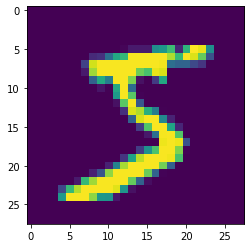

In [11]:
plt.imshow(numpy_img);

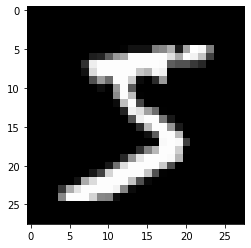

In [12]:
plt.imshow(numpy_img, cmap='gray');

Отрисовка заданной цифры:

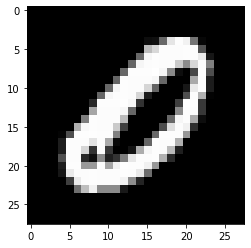

In [13]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=60000)

plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [14]:
i=0
for data in trainloader:
    print(len(data))
    print('Images:',data[0])
    print('Labels:', data[1])
    #i = i+1
    #if i==5:
    break

2
Images: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0.,

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [15]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [16]:
# # Заметьте: класс наследуется от nn.Module
# class SimpleConvNet(nn.Module):
#     def __init__(self):
#         # вызов конструктора предка
#         super(SimpleConvNet, self).__init__()
#         # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
#         # которую будем подавать в сеть, больше ничего
#         # про входящие картинки знать не нужно
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#         self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         # print(x.shape)
#         x = x.view(-1, 4 * 4 * 16)  # !!!
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятное сходу число `4 * 4 * 16`. Это -- размерность тензора перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в `C * H * W` нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [17]:
from tqdm import tqdm_notebook, tqdm

In [18]:
# # объявляем сеть
# net = SimpleConvNet()

# # выбираем функцию потерь
# loss_fn = torch.nn.CrossEntropyLoss()

# # выбираем алгоритм оптимизации и learning_rate
# learning_rate = 1e-4
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# # итерируемся
# for epoch in tqdm_notebook(range(3)):

#     running_loss = 0.0
#     for i, batch in enumerate(tqdm_notebook(trainloader)):
#         # так получаем текущий батч
#         X_batch, y_batch = batch
        
#         # обнуляем веса
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         y_pred = net(X_batch)
#         loss = loss_fn(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()

#         # выведем текущий loss
#         running_loss += loss.item()
#         # выведем качество каждые 2000 батчей
#         if i % 2000 == 1999:
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [19]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))

# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         y_pred = net(images)
#         _, predicted = torch.max(y_pred, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

Два свёрточных слоя победили многослойную нейросеть (из ноутбука с домашним заданием). Это показывает эффективность применения операции свёртки при работе с изображениями.

Протестируем эту нейросеть на отдельных картинках из тестового датасета: напишием функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

In [20]:
# i = np.random.randint(low=0, high=10000)

# def visualize_result(index):
#     image = testloader.dataset.test_data[index].numpy()
#     plt.imshow(image, cmap='gray')
    
#     y_pred = net(torch.Tensor(image).view(1, 1, 28, 28))
#     print(y_pred)
#     pred, predicted = torch.max(y_pred, 1)
#     print(pred)

#     #batch = testloader.dataset.test_data[index]
#     #print(batch[1])
#     #loss = loss_fn(y_pred, y_batch)
    
#     plt.title(f'Predicted: {predicted}')

# visualize_result(i)

Можете запускать ячейку выше много раз (нажимая Ctrl+Enter) и видеть, что предсказывает нейросеть в зависимости от поданной на вход картинки.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). Курс Стэнфорда:  http://cs231n.github.io/

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M

---

In [22]:
def get_f_name(f):
  arr = str(f).split(' ')
  name = arr[1]
  if name == 'method':
    name = arr[2]
  return name #  + f'<{str(f)}>'

In [23]:
import pandas as pd
global_res = pd.DataFrame(columns=['channels1', 'channels2', 'channels3', 'kernel_size1', 'kernel_size2', 'kernel_size3', 'fc1', 'fc2', 'fc3', 'is_max_pool', 'activation', 'avg', 'max', 'min', 'ch_c', 'conv_c', 'fc_c'])

In [24]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(str(device))

cpu


In [25]:
class SimpleConvNet_my(nn.Module):
    def __init__(self, channels1, channels2, kernel_size1, kernel_size2, fc1, fc2, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.fc1_c = fc1
        self.fc2_c = fc2
        self.is_max_pool = is_max_pool
        self.activation = activation

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 28 - kernel_size1 + 1
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        new_size = new_size // 2
        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2

        self.fc1_size = new_size * new_size * channels2

        self.fc1 = nn.Linear(new_size * new_size * channels2, fc1)  # !!!
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        #print(x.shape)
        x = self.pool(self.activation(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, self.fc1_size)  # !!!
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('fin')

    def validatee(self):
      class_correct = list(0. for i in range(10))
      class_total = list(0. for i in range(10))

      with torch.no_grad():
          for data in testloader:
              images, labels = data
              y_pred = self(images)
              _, predicted = torch.max(y_pred, 1)
              c = (predicted == labels).squeeze()
              for i in range(4):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1
      res = []
      for i in range(10):
          tmp = 100 * class_correct[i] / class_total[i]
          res.append(tmp)
          print('Accuracy of %2s : %2d %%' % (
              classes[i], tmp))
          
      class_correct_t = sum(class_correct)
      class_total_t = sum(class_total)

      rrr = (100. * class_correct_t / class_total_t)
      print('\nTotal accuracy AVG:', rrr)
      print(f'max={max(res)}; min={min(res)}')  
      rezzz = [
              self.channels1,
              self.channels2,
              0, 
              self.kernel_size1,
              self.kernel_size2,
              0,
              self.fc1_c,
              self.fc2_c,
              0, 
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              2,
              2,
              2
      ]    
      global_res.loc[len(global_res)] = rezzz

In [26]:
functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink] 
kernels = [[5, 5], [7, 3]]
fcs = [[120, 84], [200, 100]]
is_max_pools = [True, False]

In [27]:
def print_res(df):
    return df.sort_values(by=['avg'], ascending=False)

In [28]:
# for function in tqdm_notebook(functions):
#     for kernel in tqdm_notebook(kernels):
#         for fc in tqdm_notebook(fcs):
#             for is_max_pool in tqdm_notebook(is_max_pools): 
#                 net = SimpleConvNet_my(6, 16, kernel[0], kernel[1], fc[0], fc[1], is_max_pool, function)
#                 net.to(device)
#                 net.train()
#                 net.validatee()
#                 print_res(global_res)
        

In [50]:
# global_res.to_csv('f6.csv', sep='\t', encoding='utf-8')
# 

In [30]:
# global_res = pd.DataFrame(columns=['channels1', 'channels2', 'channels3', 'kernel_size1', 'kernel_size2', 'kernel_size3', 'fc1', 'fc2', 'fc3', 'is_max_pool', 'activation', 'avg', 'max', 'min', 'ch_c', 'conv_c', 'fc_c'])

In [51]:
# global_res = pd.read_csv('f6.csv', sep='\t', encoding='utf-8')
# del global_res['Unnamed: 0']
# global_res.insert(2, 'channels3', 0)
# global_res.insert(5, 'kernel_size3', 0)
# global_res.insert(8, 'fc3', 0)
# global_res['ch_c'] = 2
# global_res['conv_c'] = 2
# global_res['fc_c'] = 2
# print_res(global_res)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c
10,6,16,0,5,5,0,200,100,0,True,elu,98.53,99.30,97.98,2,2,2
32,6,16,0,5,5,0,120,84,0,True,tanh,98.49,99.47,96.43,2,2,2
26,6,16,0,5,5,0,200,100,0,True,softsign,98.43,99.82,96.04,2,2,2
34,6,16,0,5,5,0,200,100,0,True,tanh,98.32,98.94,96.73,2,2,2
2,6,16,0,5,5,0,200,100,0,True,relu,98.29,99.82,96.33,2,2,2
12,6,16,0,7,3,0,120,84,0,True,elu,98.25,99.29,94.75,2,2,2
36,6,16,0,7,3,0,120,84,0,True,tanh,98.24,99.30,96.61,2,2,2
14,6,16,0,7,3,0,200,100,0,True,elu,98.21,99.08,95.64,2,2,2
24,6,16,0,5,5,0,120,84,0,True,softsign,98.17,99.03,96.63,2,2,2
0,6,16,0,5,5,0,120,84,0,True,relu,98.16,99.74,96.83,2,2,2


In [47]:
# global_res.to_csv('f6+.csv', sep='\t', encoding='utf-8')

Вывод:
лучше использовать elu или tanh с размером fc [200, 100] и макс пуллингом и размером ядер [5, 5]

In [53]:
class SimpleConvNet_my_3_conv(nn.Module):
    def __init__(self, channels1, channels2, channels3, kernel_size1, kernel_size2, kernel_size3, fc1, fc2, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my_3_conv, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.channels3 = channels3
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.kernel_size3 = kernel_size3
        self.fc1_c = fc1
        self.fc2_c = fc2
        self.is_max_pool = is_max_pool
        self.activation = activation

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 28 - kernel_size1 + 1

        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        new_size = new_size // 2
        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2

        self.conv3 = nn.Conv2d(in_channels=channels2, out_channels=channels3, kernel_size=kernel_size3)
        new_size = new_size - kernel_size3 + 1
        #new_size = new_size // 2
        #print(new_size)
        self.fc1_size = new_size * new_size * channels3

        self.fc1 = nn.Linear(new_size * new_size * channels3, fc1)  # !!!
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        #print(x.shape)
        x = self.pool(self.activation(self.conv2(x)))
        #print(x.shape)
        x = self.activation(self.conv3(x))         #x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = x.view(-1, self.fc1_size)  # !!!
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('fin')

    def validatee(self):
      class_correct = list(0. for i in range(10))
      class_total = list(0. for i in range(10))

      with torch.no_grad():
          for data in testloader:
              images, labels = data
              y_pred = self(images)
              _, predicted = torch.max(y_pred, 1)
              c = (predicted == labels).squeeze()
              for i in range(4):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1
      res = []
      for i in range(10):
          tmp = 100 * class_correct[i] / class_total[i]
          res.append(tmp)
          print('Accuracy of %2s : %2d %%' % (
              classes[i], tmp))
          
      class_correct_t = sum(class_correct)
      class_total_t = sum(class_total)

      rrr = (100. * class_correct_t / class_total_t)
      print('\nTotal accuracy AVG:', rrr)
      print(f'max={max(res)}; min={min(res)}')  
      rezzz = [
              self.channels1,
              self.channels2,
              self.channels3,
              self.kernel_size1,
              self.kernel_size2,
              self.kernel_size3,
              self.fc1_c,
              self.fc2_c,
              0,
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              3,
              3,
              2
      ]    
      global_res.loc[len(global_res)] = rezzz

In [52]:
# functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink] 
functions = [F.elu, torch.tanh] 
kernels = [[3, 3, 5]]
fcs = [[120, 84], [200, 100]]
is_max_pools = [True]

In [54]:
for function in tqdm_notebook(functions):
    for kernel in tqdm_notebook(kernels):
        for fc in tqdm_notebook(fcs):
            for is_max_pool in tqdm_notebook(is_max_pools): 
                net = SimpleConvNet_my_3_conv(6, 16, 30, kernel[0], kernel[1], kernel[2], fc[0], fc[1], is_max_pool, function)
                net.to(device)
                net.train()
                net.validatee()
                print_res(global_res)

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/3317418457.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for function in tqdm_notebook(functions):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/3317418457.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kernel in tqdm_notebook(kernels):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/3317418457.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fc in tqdm_notebook(fcs):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/3317418457.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for is_max_pool in tqdm_notebook(is_max_pools):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/2264763836.py:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/2264763836.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.005
[1,  4000] loss: 0.377
[1,  6000] loss: 0.307
[1,  8000] loss: 0.238
[1, 10000] loss: 0.227
[1, 12000] loss: 0.194
[1, 14000] loss: 0.175


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.145
[2,  4000] loss: 0.137
[2,  6000] loss: 0.120
[2,  8000] loss: 0.114
[2, 10000] loss: 0.115
[2, 12000] loss: 0.107
[2, 14000] loss: 0.101


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.088
[3,  4000] loss: 0.088
[3,  6000] loss: 0.084
[3,  8000] loss: 0.091
[3, 10000] loss: 0.085
[3, 12000] loss: 0.079
[3, 14000] loss: 0.080
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 99 %
Accuracy of  2 : 96 %
Accuracy of  3 : 98 %
Accuracy of  4 : 96 %
Accuracy of  5 : 98 %
Accuracy of  6 : 94 %
Accuracy of  7 : 97 %
Accuracy of  8 : 98 %
Accuracy of  9 : 96 %

Total accuracy AVG: 97.56
max=99.55947136563877; min=94.57202505219206


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.959
[1,  4000] loss: 0.324
[1,  6000] loss: 0.249
[1,  8000] loss: 0.203
[1, 10000] loss: 0.180
[1, 12000] loss: 0.147
[1, 14000] loss: 0.133


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.126
[2,  4000] loss: 0.108
[2,  6000] loss: 0.101
[2,  8000] loss: 0.096
[2, 10000] loss: 0.098
[2, 12000] loss: 0.092
[2, 14000] loss: 0.089


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.087
[3,  4000] loss: 0.082
[3,  6000] loss: 0.079
[3,  8000] loss: 0.076
[3, 10000] loss: 0.071
[3, 12000] loss: 0.077
[3, 14000] loss: 0.066
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 97 %
Accuracy of  4 : 97 %
Accuracy of  5 : 97 %
Accuracy of  6 : 97 %
Accuracy of  7 : 97 %
Accuracy of  8 : 99 %
Accuracy of  9 : 95 %

Total accuracy AVG: 97.83
max=99.47136563876651; min=95.24281466798811


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.136
[1,  4000] loss: 0.425
[1,  6000] loss: 0.301
[1,  8000] loss: 0.240
[1, 10000] loss: 0.200
[1, 12000] loss: 0.188
[1, 14000] loss: 0.162


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.147
[2,  4000] loss: 0.127
[2,  6000] loss: 0.121
[2,  8000] loss: 0.121
[2, 10000] loss: 0.102
[2, 12000] loss: 0.094
[2, 14000] loss: 0.099


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.094
[3,  4000] loss: 0.093
[3,  6000] loss: 0.091
[3,  8000] loss: 0.089
[3, 10000] loss: 0.076
[3, 12000] loss: 0.076
[3, 14000] loss: 0.079
fin
Accuracy of  0 : 98 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 97 %
Accuracy of  5 : 97 %
Accuracy of  6 : 98 %
Accuracy of  7 : 97 %
Accuracy of  8 : 96 %
Accuracy of  9 : 95 %

Total accuracy AVG: 97.86
max=99.20704845814979; min=95.93657086223985


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.159
[1,  4000] loss: 0.428
[1,  6000] loss: 0.281
[1,  8000] loss: 0.238
[1, 10000] loss: 0.197
[1, 12000] loss: 0.184
[1, 14000] loss: 0.164


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.133
[2,  4000] loss: 0.140
[2,  6000] loss: 0.121
[2,  8000] loss: 0.127
[2, 10000] loss: 0.097
[2, 12000] loss: 0.095
[2, 14000] loss: 0.109


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.091
[3,  4000] loss: 0.085
[3,  6000] loss: 0.087
[3,  8000] loss: 0.086
[3, 10000] loss: 0.075
[3, 12000] loss: 0.086
[3, 14000] loss: 0.078
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 99 %
Accuracy of  2 : 97 %
Accuracy of  3 : 98 %
Accuracy of  4 : 97 %
Accuracy of  5 : 97 %
Accuracy of  6 : 96 %
Accuracy of  7 : 97 %
Accuracy of  8 : 97 %
Accuracy of  9 : 97 %

Total accuracy AVG: 98.06
max=99.38325991189427; min=96.97286012526096


In [55]:
print_res(global_res)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c
10,6,16,0,5,5,0,200,100,0,True,elu,98.53,99.30,97.98,2,2,2
32,6,16,0,5,5,0,120,84,0,True,tanh,98.49,99.47,96.43,2,2,2
26,6,16,0,5,5,0,200,100,0,True,softsign,98.43,99.82,96.04,2,2,2
34,6,16,0,5,5,0,200,100,0,True,tanh,98.32,98.94,96.73,2,2,2
2,6,16,0,5,5,0,200,100,0,True,relu,98.29,99.82,96.33,2,2,2
12,6,16,0,7,3,0,120,84,0,True,elu,98.25,99.29,94.75,2,2,2
36,6,16,0,7,3,0,120,84,0,True,tanh,98.24,99.30,96.61,2,2,2
14,6,16,0,7,3,0,200,100,0,True,elu,98.21,99.08,95.64,2,2,2
24,6,16,0,5,5,0,120,84,0,True,softsign,98.17,99.03,96.63,2,2,2
0,6,16,0,5,5,0,120,84,0,True,relu,98.16,99.74,96.83,2,2,2


In [56]:
# global_res.to_csv('f3-3-2.csv', sep='\t', encoding='utf-8')

In [ ]:
# global_res = pd.read_csv('f3-3-2.csv', sep='\t', encoding='utf-8')

In [63]:
class SimpleConvNet_my_3_fc(nn.Module):
    def __init__(self, channels1, channels2, kernel_size1, kernel_size2, fc1, fc2, fc3, is_max_pool = True, activation=F.relu):
        # вызов конструктора предка
        super(SimpleConvNet_my_3_fc, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.channels1 = channels1
        self.channels2 = channels2
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.fc1_c = fc1
        self.fc2_c = fc2
        self.fc3_c = fc3
        self.is_max_pool = is_max_pool
        self.activation = activation

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels1, kernel_size=kernel_size1)
        new_size = 28 - kernel_size1 + 1
        if is_max_pool:
          self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
          self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        new_size = new_size // 2
        self.conv2 = nn.Conv2d(in_channels=channels1, out_channels=channels2, kernel_size=kernel_size2)
        new_size = new_size - kernel_size2 + 1
        new_size = new_size // 2

        self.fc1_size = new_size * new_size * channels2

        self.fc1 = nn.Linear(new_size * new_size * channels2, fc1)  # !!!
        self.fc2 = nn.Linear(fc1, fc2)
        self.fc3 = nn.Linear(fc2, fc3)
        self.fc4 = nn.Linear(fc3, 10)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        #print(x.shape)
        x = self.pool(self.activation(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, self.fc1_size)  # !!!
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

    def train(self, learning_rate = 1e-4, num_epochs = 3):
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        # итерируемся
        for epoch in tqdm_notebook(range(num_epochs)):
            running_loss = 0.0
            for i, batch in enumerate(tqdm_notebook(trainloader)):
                # так получаем текущий батч
                X_batch, y_batch = batch
                global device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # обнуляем веса
                optimizer.zero_grad()

                # forward + backward + optimize
                y_pred = self(X_batch)
                loss = loss_fn(y_pred, y_batch)
                loss.backward()
                optimizer.step()

                # выведем текущий loss
                running_loss += loss.item()
                # выведем качество каждые 2000 батчей
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
          
        print('fin')

    def validatee(self):
      class_correct = list(0. for i in range(10))
      class_total = list(0. for i in range(10))

      with torch.no_grad():
          for data in testloader:
              images, labels = data
              y_pred = self(images)
              _, predicted = torch.max(y_pred, 1)
              c = (predicted == labels).squeeze()
              for i in range(4):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1
      res = []
      for i in range(10):
          tmp = 100 * class_correct[i] / class_total[i]
          res.append(tmp)
          print('Accuracy of %2s : %2d %%' % (
              classes[i], tmp))
          
      class_correct_t = sum(class_correct)
      class_total_t = sum(class_total)

      rrr = (100. * class_correct_t / class_total_t)
      print('\nTotal accuracy AVG:', rrr)
      print(f'max={max(res)}; min={min(res)}')  
      rezzz = [
              self.channels1,
              self.channels2,
              0,
              self.kernel_size1,
              self.kernel_size2,
              0,
              self.fc1_c,
              self.fc2_c,
              self.fc3_c,
              self.is_max_pool,
              get_f_name(self.activation),
              rrr,
              round(max(res), 2),
              round(min(res), 2),
              2,
              2,
              3
      ]    
      global_res.loc[len(global_res)] = rezzz

In [58]:
# functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink] 
functions = [F.elu, torch.tanh] 
kernels = [[3, 3], [5, 5]]
fcs = [[128, 64, 32], [256, 128, 64]]
is_max_pools = [True]

In [65]:
for function in tqdm_notebook(functions):
    for kernel in tqdm_notebook(kernels):
        for fc in tqdm_notebook(fcs):
            for is_max_pool in tqdm_notebook(is_max_pools): 
                net = SimpleConvNet_my_3_fc(6, 16, kernel[0], kernel[1], fc[0], fc[1], fc[2], is_max_pool, function)
                net.to(device)
                net.train()
                net.validatee()
                print_res(global_res)

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/1410717438.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for function in tqdm_notebook(functions):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/1410717438.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kernel in tqdm_notebook(kernels):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/1410717438.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fc in tqdm_notebook(fcs):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/1410717438.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for is_max_pool in tqdm_notebook(is_max_pools):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/2870665598.py:52: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/2870665598.py:54: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.993
[1,  4000] loss: 0.402
[1,  6000] loss: 0.308
[1,  8000] loss: 0.247
[1, 10000] loss: 0.225
[1, 12000] loss: 0.197
[1, 14000] loss: 0.187


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.144
[2,  4000] loss: 0.129
[2,  6000] loss: 0.129
[2,  8000] loss: 0.100
[2, 10000] loss: 0.106
[2, 12000] loss: 0.107
[2, 14000] loss: 0.105


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.086
[3,  4000] loss: 0.089
[3,  6000] loss: 0.080
[3,  8000] loss: 0.075
[3, 10000] loss: 0.079
[3, 12000] loss: 0.064
[3, 14000] loss: 0.078
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 98 %
Accuracy of  2 : 96 %
Accuracy of  3 : 98 %
Accuracy of  4 : 98 %
Accuracy of  5 : 98 %
Accuracy of  6 : 98 %
Accuracy of  7 : 96 %
Accuracy of  8 : 97 %
Accuracy of  9 : 96 %

Total accuracy AVG: 98.01
max=99.08163265306122; min=96.82854311199208


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.889
[1,  4000] loss: 0.350
[1,  6000] loss: 0.283
[1,  8000] loss: 0.229
[1, 10000] loss: 0.181
[1, 12000] loss: 0.156
[1, 14000] loss: 0.144


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.109
[2,  4000] loss: 0.106
[2,  6000] loss: 0.095
[2,  8000] loss: 0.098
[2, 10000] loss: 0.089
[2, 12000] loss: 0.094
[2, 14000] loss: 0.089


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.074
[3,  4000] loss: 0.073
[3,  6000] loss: 0.069
[3,  8000] loss: 0.068
[3, 10000] loss: 0.063
[3, 12000] loss: 0.072
[3, 14000] loss: 0.064
fin
Accuracy of  0 : 98 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 98 %
Accuracy of  5 : 95 %
Accuracy of  6 : 98 %
Accuracy of  7 : 98 %
Accuracy of  8 : 98 %
Accuracy of  9 : 97 %

Total accuracy AVG: 98.28
max=99.29515418502203; min=95.85201793721973


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.011
[1,  4000] loss: 0.401
[1,  6000] loss: 0.321
[1,  8000] loss: 0.261
[1, 10000] loss: 0.238
[1, 12000] loss: 0.198
[1, 14000] loss: 0.182


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.142
[2,  4000] loss: 0.136
[2,  6000] loss: 0.130
[2,  8000] loss: 0.117
[2, 10000] loss: 0.113
[2, 12000] loss: 0.094
[2, 14000] loss: 0.092


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.077
[3,  4000] loss: 0.087
[3,  6000] loss: 0.084
[3,  8000] loss: 0.078
[3, 10000] loss: 0.076
[3, 12000] loss: 0.071
[3, 14000] loss: 0.078
fin
Accuracy of  0 : 98 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 97 %
Accuracy of  4 : 99 %
Accuracy of  5 : 97 %
Accuracy of  6 : 99 %
Accuracy of  7 : 97 %
Accuracy of  8 : 95 %
Accuracy of  9 : 94 %

Total accuracy AVG: 97.88
max=99.59266802443992; min=94.05351833498513


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.750
[1,  4000] loss: 0.265
[1,  6000] loss: 0.191
[1,  8000] loss: 0.174
[1, 10000] loss: 0.134
[1, 12000] loss: 0.129
[1, 14000] loss: 0.111


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.086
[2,  4000] loss: 0.095
[2,  6000] loss: 0.085
[2,  8000] loss: 0.086
[2, 10000] loss: 0.080
[2, 12000] loss: 0.075
[2, 14000] loss: 0.075


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.060
[3,  4000] loss: 0.058
[3,  6000] loss: 0.069
[3,  8000] loss: 0.064
[3, 10000] loss: 0.063
[3, 12000] loss: 0.058
[3, 14000] loss: 0.052
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 97 %
Accuracy of  5 : 97 %
Accuracy of  6 : 99 %
Accuracy of  7 : 97 %
Accuracy of  8 : 98 %
Accuracy of  9 : 96 %

Total accuracy AVG: 98.35
max=99.29515418502203; min=96.72943508424183


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.267
[1,  4000] loss: 0.504
[1,  6000] loss: 0.302
[1,  8000] loss: 0.219
[1, 10000] loss: 0.183
[1, 12000] loss: 0.165
[1, 14000] loss: 0.154


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.124
[2,  4000] loss: 0.115
[2,  6000] loss: 0.101
[2,  8000] loss: 0.106
[2, 10000] loss: 0.095
[2, 12000] loss: 0.096
[2, 14000] loss: 0.083


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.081
[3,  4000] loss: 0.074
[3,  6000] loss: 0.078
[3,  8000] loss: 0.079
[3, 10000] loss: 0.057
[3, 12000] loss: 0.070
[3, 14000] loss: 0.064
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 98 %
Accuracy of  5 : 97 %
Accuracy of  6 : 97 %
Accuracy of  7 : 98 %
Accuracy of  8 : 98 %
Accuracy of  9 : 96 %

Total accuracy AVG: 98.33
max=99.55947136563877; min=96.63032705649158


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.952
[1,  4000] loss: 0.361
[1,  6000] loss: 0.248
[1,  8000] loss: 0.205
[1, 10000] loss: 0.180
[1, 12000] loss: 0.164
[1, 14000] loss: 0.148


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.114
[2,  4000] loss: 0.118
[2,  6000] loss: 0.104
[2,  8000] loss: 0.106
[2, 10000] loss: 0.099
[2, 12000] loss: 0.097
[2, 14000] loss: 0.090


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.077
[3,  4000] loss: 0.083
[3,  6000] loss: 0.078
[3,  8000] loss: 0.071
[3, 10000] loss: 0.073
[3, 12000] loss: 0.068
[3, 14000] loss: 0.071
fin
Accuracy of  0 : 98 %
Accuracy of  1 : 98 %
Accuracy of  2 : 96 %
Accuracy of  3 : 97 %
Accuracy of  4 : 98 %
Accuracy of  5 : 98 %
Accuracy of  6 : 98 %
Accuracy of  7 : 97 %
Accuracy of  8 : 98 %
Accuracy of  9 : 96 %

Total accuracy AVG: 97.99
max=98.94273127753304; min=96.53121902874133


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.318
[1,  4000] loss: 0.603
[1,  6000] loss: 0.403
[1,  8000] loss: 0.288
[1, 10000] loss: 0.239
[1, 12000] loss: 0.196
[1, 14000] loss: 0.173


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.129
[2,  4000] loss: 0.135
[2,  6000] loss: 0.121
[2,  8000] loss: 0.104
[2, 10000] loss: 0.111
[2, 12000] loss: 0.100
[2, 14000] loss: 0.088


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.089
[3,  4000] loss: 0.077
[3,  6000] loss: 0.078
[3,  8000] loss: 0.070
[3, 10000] loss: 0.071
[3, 12000] loss: 0.066
[3, 14000] loss: 0.069
fin
Accuracy of  0 : 98 %
Accuracy of  1 : 99 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 97 %
Accuracy of  5 : 98 %
Accuracy of  6 : 98 %
Accuracy of  7 : 98 %
Accuracy of  8 : 98 %
Accuracy of  9 : 96 %

Total accuracy AVG: 98.17
max=99.11894273127753; min=96.13478691774034


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.935
[1,  4000] loss: 0.338
[1,  6000] loss: 0.243
[1,  8000] loss: 0.197
[1, 10000] loss: 0.165
[1, 12000] loss: 0.154
[1, 14000] loss: 0.135


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.113
[2,  4000] loss: 0.110
[2,  6000] loss: 0.107
[2,  8000] loss: 0.104
[2, 10000] loss: 0.081
[2, 12000] loss: 0.085
[2, 14000] loss: 0.089


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.073
[3,  4000] loss: 0.072
[3,  6000] loss: 0.073
[3,  8000] loss: 0.068
[3, 10000] loss: 0.076
[3, 12000] loss: 0.069
[3, 14000] loss: 0.066
fin
Accuracy of  0 : 99 %
Accuracy of  1 : 98 %
Accuracy of  2 : 98 %
Accuracy of  3 : 98 %
Accuracy of  4 : 98 %
Accuracy of  5 : 97 %
Accuracy of  6 : 98 %
Accuracy of  7 : 98 %
Accuracy of  8 : 97 %
Accuracy of  9 : 96 %

Total accuracy AVG: 98.3
max=99.38775510204081; min=96.92765113974232


In [66]:
print_res(global_res).head(5)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c
10,6,16,0,5,5,0,200,100,0,True,elu,98.53,99.30,97.98,2,2,2
32,6,16,0,5,5,0,120,84,0,True,tanh,98.49,99.47,96.43,2,2,2
26,6,16,0,5,5,0,200,100,0,True,softsign,98.43,99.82,96.04,2,2,2
55,6,16,0,5,5,0,256,128,64,True,elu,98.35,99.30,96.73,2,2,3
56,6,16,0,3,3,0,128,64,32,True,tanh,98.33,99.56,96.63,2,2,3
34,6,16,0,5,5,0,200,100,0,True,tanh,98.32,98.94,96.73,2,2,2
59,6,16,0,5,5,0,256,128,64,True,tanh,98.30,99.39,96.93,2,2,3
2,6,16,0,5,5,0,200,100,0,True,relu,98.29,99.82,96.33,2,2,2
53,6,16,0,3,3,0,256,128,64,True,elu,98.28,99.30,95.85,2,2,3
12,6,16,0,7,3,0,120,84,0,True,elu,98.25,99.29,94.75,2,2,2


In [67]:
# global_res.to_csv('f-final.csv', sep='\t', encoding='utf-8')

In [68]:
print_res(global_res).head(5)

,channels1,channels2,channels3,kernel_size1,kernel_size2,kernel_size3,fc1,fc2,fc3,is_max_pool,activation,avg,max,min,ch_c,conv_c,fc_c
10,6,16,0,5,5,0,200,100,0,True,elu,98.53,99.30,97.98,2,2,2
32,6,16,0,5,5,0,120,84,0,True,tanh,98.49,99.47,96.43,2,2,2
26,6,16,0,5,5,0,200,100,0,True,softsign,98.43,99.82,96.04,2,2,2
55,6,16,0,5,5,0,256,128,64,True,elu,98.35,99.30,96.73,2,2,3
56,6,16,0,3,3,0,128,64,32,True,tanh,98.33,99.56,96.63,2,2,3


ИТОГИ
В пятекрке лучших оказались функции elu и tanh

Наращивание слоя конволюшена особо ничего не дало.

В изученных ядрах лучше всего себя показали ядра размером 5 в каждом последующем слое.
Уменьшение размера до 3 дало среднее падение на 0.2%

Добавление слоя fc в целом показало себя не плохо (попало в 5 лучших)

Average pooling работал хуже, чем Max.

Кошкарев Алексей 20223

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(str(device))

cuda:0


In [71]:
net = SimpleConvNet_my(6, 16, 3, 3, 64, 32, True)
net.to(device)
net.train(num_epochs=1)
net.validatee()
print_res(global_res)

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/772932279.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(num_epochs)):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\KOSHI8~1\AppData\Local\Temp/ipykernel_4768/772932279.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 1.274
[1,  4000] loss: 0.426
[1,  6000] loss: 0.338
[1,  8000] loss: 0.283
[1, 10000] loss: 0.243
[1, 12000] loss: 0.227
[1, 14000] loss: 0.204
fin


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor